In [1]:
# !pip install 'qiskit[visualization]'
# !pip install qiskit_aer
# !pip install qiskit_ibm_runtime

In [2]:
import qiskit
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_distribution
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.classical import expr
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_bloch_vector
from qiskit.visualization.bloch import Bloch
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
import math
import numpy as np
import matplotlib.pyplot as plt

### "Quantum" CHSH game

This time Alice and Bob read x and y in superposition value of 0 and 1.  Then, apply their operators accordingly.

Define helper functions.

In [3]:
def is_win(x, y, a, b):
    """
    x, y, a, b are 0 or 1
    return true if x and y = a xor b
    """
    if x==1 and y==1:
        if a != b:
            return True
        else:
            return False
    else:
        if a == b:
            return True
        else:
            return False

In [4]:
def get_win_prob(dist):
    count_win = 0
    count_loss = 0
    for k, v in dist.items():
        x = int(k[3]) # measured bit 0 is rightmost char [3] in string
        y = int(k[2])
        a = int(k[1])
        b = int(k[0])
        if is_win(x, y, a, b):
            count_win += v
        else:
            count_loss += v
    return count_win / (count_win + count_loss)

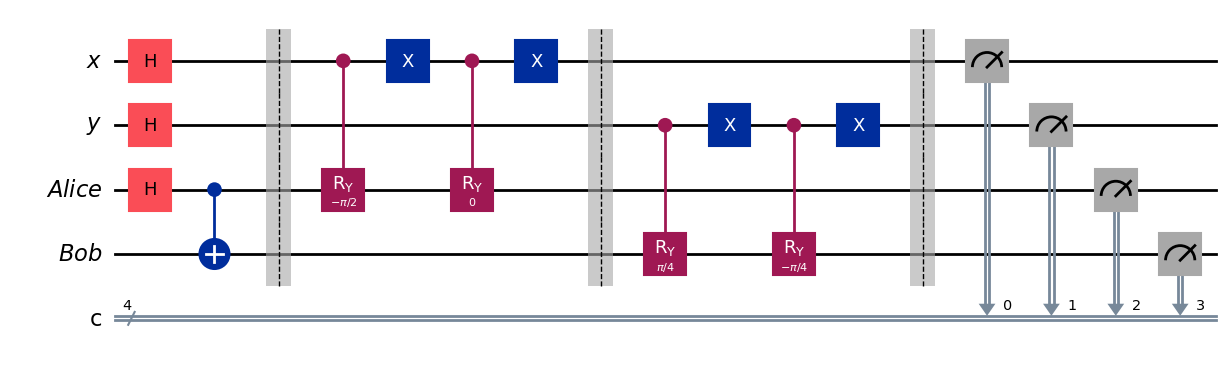

In [5]:
xreg = QuantumRegister(1, "x")
yreg = QuantumRegister(1, "y")
areg = QuantumRegister(1, "Alice")
breg = QuantumRegister(1, "Bob")
c_reg = ClassicalRegister(4, "c") # bit 0, 1, 2, 3 as x, y, a, b

qc = QuantumCircuit(xreg, yreg, areg, breg, c_reg)
qc.h(xreg)
qc.h(yreg)
qc.h(areg)
qc.cx(areg, breg)
qc.barrier()

# Apply Alice's operators accordingly
qc.cry(-np.pi/2, xreg, areg)
qc.x(xreg)
qc.cry(0, xreg, areg)
qc.x(xreg)
qc.barrier()

# Apply Bob's operators accordingly
qc.cry(np.pi/4, yreg, breg)
qc.x(yreg)
qc.cry(-np.pi/4, yreg, breg)
qc.x(yreg)
qc.barrier()

# measure x, y, a, b
qc.measure(xreg, c_reg[0])
qc.measure(yreg, c_reg[1])
qc.measure(areg, c_reg[2])
qc.measure(breg, c_reg[3])
display(qc.draw('mpl'))

In [6]:
sampler = Sampler(mode=AerSimulator())
job = sampler.run([qc])
result = job.result()[0]
samp_dist = result.data.c.get_counts()
print(samp_dist)
count_win = 0
count_loss = 0
for k, v in samp_dist.items():
    x = int(k[3]) # measured bit 0 is rightmost char [3] in string
    y = int(k[2])
    a = int(k[1])
    b = int(k[0])
    if is_win(x, y, a, b):
        count_win += v
    else:
        count_loss += v
print(count_win, count_loss)
print(count_win / (count_win + count_loss))

{'1101': 102, '0001': 122, '0111': 107, '1111': 18, '1001': 17, '1110': 101, '0110': 21, '1100': 112, '0011': 27, '0010': 114, '1010': 15, '1000': 12, '1011': 122, '0100': 21, '0000': 93, '0101': 20}
873 151
0.8525390625


Got the same ideal win probability 0.85.

In [7]:
qiskit.__version__

'1.4.0'